In [1]:
import random
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


### Data Load

In [4]:
# train = pd.read_csv('../../data/train_data.csv')
# test = pd.read_csv('../../data/test_data.csv')

In [ ]:
train_idx = np.load('./train_idx.npy',allow_pickle = True)
valid_idx = np.load('./valid_idx.npy',allow_pickle = True) # 인덱스파일

### FE

Dataset of shape (2526700, 47)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote']
Parameter estimation is starting...


100%|██████████| 2526700/2526700 [00:19<00:00, 129730.50it/s]


Theta & beta estimations on assessmentItemID are completed.
Dataset of shape (2526700, 48)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID']
Parameter estimation is starting...


100%|██████████| 2526700/2526700 [00:18<00:00, 135326.78it/s]


Theta & beta estimations on problem_num are completed.
User Tag TSNE Plot
Tag User TSNE Plot


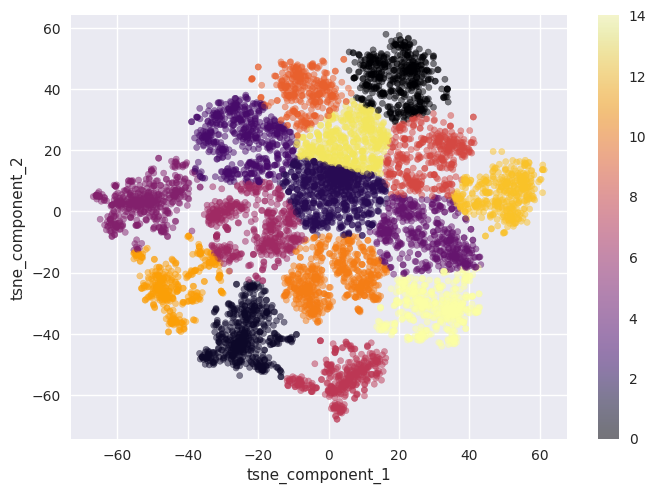

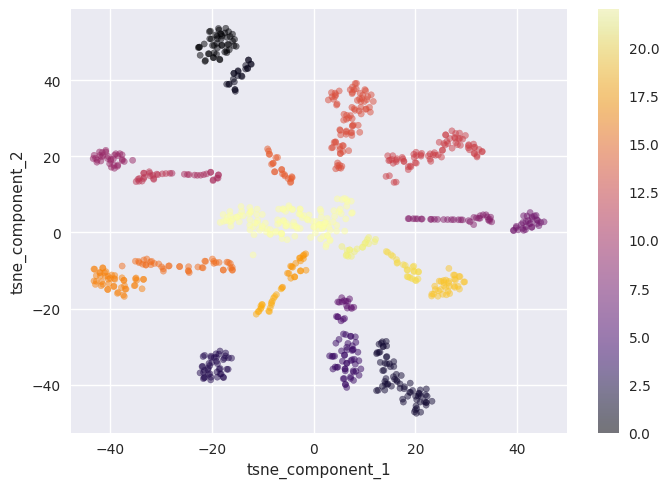

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import hdbscan
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
sys.path.append('../LGBM/')
from utils import apply_elo_granularity_feature_name


def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}
def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
#     big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
#     big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
#     df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
#     df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['big_category_user_cum_acc'] = (df2['big_category_answer'] / df2['big_category_cumconut']).fillna(0)
    
    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_big_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
#     df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])
    
#     df2_user_big_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
#     df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])   
    
    ## mid_category
    # mid_category 전체 정답률, 표준편차
#     mid_category_answermean = dict(df2.groupby("mid_category").answerCode.mean())
#     mid_category_answerstd = dict(df2.groupby("mid_category").answerCode.std())
#     df2['mid_category_acc'] = df2.mid_category.map(mid_category_answermean)
#     df2['mid_category_std'] = df2.mid_category.map(mid_category_answerstd)

    # 유저별 mid category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['mid_category_cumconut'] = df2.groupby(['userID','mid_category']).answerCode.cumcount()
    df2['mid_category_answer'] = df2.groupby(['userID','mid_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['mid_category_user_cum_acc'] = (df2['mid_category_answer'] / df2['mid_category_cumconut']).fillna(0)

    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_mid_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.mean().reset_index()
#     df2_user_mid_ans.rename(columns={'answerCode':'mid_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans,on=['userID','mid_category'])

#     df2_user_mid_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.std().reset_index()
#     df2_user_mid_ans_std.rename(columns={'answerCode':'mid_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans_std,on=['userID','mid_category']) 


    ### 문항별 난이도
    ass_acc_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.mean())
    df2['ass_acc_mean'] = df2.assessmentItemID.map(ass_acc_dict)
    df2['ass_difficulty'] = 1 - df2['ass_acc_mean']
    
    ass_acc_std_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.std())
    df2['ass_acc_std'] = df2.assessmentItemID.map(ass_acc_std_dict)

    ### 문제 번호별 난이도
    pb_num_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.mean())
    df2['pb_num_acc_mean'] = df2.problem_num.map(pb_num_dict)
    df2['pb_num_difficulty'] = 1 - df2['pb_num_acc_mean']
    
    pb_num_std_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.std())
    df2['pb_num_acc_std'] = df2.problem_num.map(pb_num_std_dict)
    
    ## assess_count
    df2['assess_count'] = df2.groupby(['userID','assessmentItemID']).answerCode.cumcount()
    
    ## apply elo
    df2 = apply_elo_granularity_feature_name(df2, "assessmentItemID")
    df2 = apply_elo_granularity_feature_name(df2, "problem_num")
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    ## cluster
    user_tag_pivot = df2.pivot_table(values="answerCode", index="userID", columns="KnowledgeTag").fillna(0)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_user_result = tsne.fit_transform(user_tag_pivot.values)
    tsne_user_df = pd.DataFrame(tsne_user_result, columns=['tsne_component_1', 'tsne_component_2'])
    number_of_clusters=15
    kmeans = KMeans(n_clusters=number_of_clusters, n_init=number_of_clusters, random_state=42)
    kmeans_labels=kmeans.fit_predict(tsne_user_result)
    print("User Tag TSNE Plot")
    tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=kmeans_labels, colormap='inferno')
    tsne_user_dict = dict(zip(user_tag_pivot.index,kmeans_labels))
    df2['user_tag_cluster'] = df2.userID.map(tsne_user_dict)
    
    tag_user_pivot = df2.pivot_table(values="answerCode", index="KnowledgeTag", columns="userID").fillna(0)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_tag_result = tsne.fit_transform(tag_user_pivot.values)
    tsne_tag_df = pd.DataFrame(tsne_tag_result, columns=['tsne_component_1', 'tsne_component_2'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    hdbscan_labels = clusterer.fit_predict(tsne_tag_result)    
    tsne_tag_df['labels'] = hdbscan_labels
    tsne_tag_df.loc[tsne_tag_df.labels==-1,'labels']=22
    print("Tag User TSNE Plot")
    tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=tsne_tag_df.labels, colormap='inferno')
    tsne_tag_dict = dict(zip(tag_user_pivot.index, tsne_tag_df.labels))
    df2['tag_cluster'] = df2.KnowledgeTag.map(tsne_tag_dict)
    
    user_mean_acc_dict = dict(df2[df2.answerCode!=-1].groupby("userID").answerCode.mean())
    df2['user_mean_acc'] = df2.userID.map(user_mean_acc_dict)

    big_category_grp = df2[df2.answerCode!=-1].groupby(["userID",'big_category']).answerCode.mean().reset_index()
    df2 = df2.merge(big_category_grp.rename(columns={'answerCode':'big_category_acc'}), on=['userID','big_category'], how='left')

    df2['big_category_acc_category'] = list(map(lambda x: int(round(x)+1),df2.big_category_acc*10))

    big_category_grp2 = df2[df2.answerCode!=-1].groupby(["userID",'big_category']).solvesec.mean().reset_index()
    df2 = df2.merge(big_category_grp2.rename(columns={'solvesec':'big_category_mean_solvesec'}), on=['userID','big_category'], how='left')
    df2['answerCodeshift'] = df2.groupby("userID").answerCode.shift(1)

    df2['user_acc_rolling_mean_10'] = df2.groupby("userID").answerCodeshift.rolling(10, min_periods=1).mean().values

    df2['tag_count'] = df2.groupby(['userID','KnowledgeTag']).cumcount()
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)

In [2]:
def k_fold_split(df,fold):
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts())) # 유저 ID, 유저 수
    random.shuffle(users)

    max_train_data_len = len(df)/fold
    sum_of_train_data = 0
    val_idx =[[] for _ in range(fold)]
    val_set = []
    train_set = []

    idx = 0
    for k in range(fold-1):
        sum_of_train_data = 0
        for user_id, count in users[idx:]:
            sum_of_train_data += count
            if max_train_data_len < sum_of_train_data:
                break
            val_idx[k].append(user_id)
            idx += 1
            
    for i in range(idx,len(users)):
        val_idx[fold-1].append(users[i][0])

    for k in range(fold):
        train_set.append(df[df['userID'].isin(val_idx[k]) == False])
        val = df[df['userID'].isin(val_idx[k])]
        val_set.append(val[val['userID'] != val['userID'].shift(-1)])
    return train_set,val_set

In [36]:
fold = 5
train,test = k_fold_split(df,fold)
print(f"총 user 수 : {df['userID'].nunique()}")
for i in range(fold):
    print(f"train_{i} user 수 : {train[i]['userID'].nunique()}")
    print(f"test_{i} user 수 : {test[i]['userID'].nunique()}")
    print(f"겹치는 유저가 있나?? : {set(train[i]['userID'])&set(test[i]['userID'])}")

총 user 수 : 7442
train_0 user 수 : 5884
test_0 user 수 : 1558
겹치는 유저가 있나?? : set()
train_1 user 수 : 5956
test_1 user 수 : 1486
겹치는 유저가 있나?? : set()
train_2 user 수 : 5929
test_2 user 수 : 1513
겹치는 유저가 있나?? : set()
train_3 user 수 : 6028
test_3 user 수 : 1414
겹치는 유저가 있나?? : set()
train_4 user 수 : 5971
test_4 user 수 : 1471
겹치는 유저가 있나?? : set()


### model 단위 stacking 함수

In [3]:
# TabNet용
# def get_stacking_base_datasets(model,FEATS,args,X_train, X_valid, X_test, n_folds):
    
#     valid_len = []
#     y_valid = X_valid[0]['answerCode']

#     for i,v in enumerate(X_valid):
#         valid_len.append(len(v))
#         if i != 0:
#             y_valid = pd.concat([y_valid,v['answerCode']])
            
#     train_fold_pred = np.zeros((sum(valid_len) ,1 ))
#     test_pred = np.zeros((X_test.shape[0],n_folds))
#     print(model.__class__.__name__ , ' model 시작 ')
   
#     for folder_counter, (train, valid) in enumerate(zip(X_train,X_valid)):
        
#         print('\t 폴드 세트: ',folder_counter,' 시작 ')
#         X_tr = train[FEATS].drop(columns = 'answerCode').values
#         y_tr = train['answerCode'].values
#         X_te = valid[FEATS].drop(columns = 'answerCode').values
        
#         model.fit(X_tr,y_tr,eval_set = [(X_te,valid['answerCode'].values)],max_epochs = 10,patience = 3,batch_size = 1024,virtual_batch_size = 128,num_workers = 0,weights = 1,drop_last = False)       
        
#         train_fold_pred[sum(valid_len[:folder_counter]) : sum(valid_len[:folder_counter+1]), :] = model.predict_proba(X_te)[:,1].reshape(-1,1)
         
#         print('\t',folder_counter,"fold auc : ",roc_auc_score(valid['answerCode'],model.predict_proba(X_te)[:,1]))

#         test_pred[:, folder_counter] = model.predict_proba(X_test[FEATS].drop(columns = 'answerCode').values)[:,1]

#     print("\tvalid auc : ",roc_auc_score(y_valid,train_fold_pred))       
     
#     test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    
#     return train_fold_pred , test_pred_mean

In [3]:
def get_stacking_base_datasets(model,FEATS,args,X_train, X_valid, X_test, n_folds):
    
    valid_len = []
    y_valid = X_valid[0]['answerCode']

    for i,v in enumerate(X_valid):
        valid_len.append(len(v))
        if i != 0:
            y_valid = pd.concat([y_valid,v['answerCode']])
            
    train_fold_pred = np.zeros((sum(valid_len) ,1 ))
    test_pred = np.zeros((X_test.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train, valid) in enumerate(zip(X_train,X_valid)):
        
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = train[FEATS].drop(columns = 'answerCode')
        y_tr = train['answerCode']
        X_te = valid[FEATS].drop(columns = 'answerCode')
        
        
        model.fit(
            X_tr,
            y_tr,
            eval_set=(X_te,valid['answerCode'])
            **args
        )       
        
        train_fold_pred[sum(valid_len[:folder_counter]) : sum(valid_len[:folder_counter+1]), :] = model.predict_proba(X_te)[:,1].reshape(-1,1)
         
        print('\t',folder_counter,"fold auc : ",roc_auc_score(valid['answerCode'],model.predict_proba(X_te)[:,1]))

        test_pred[:, folder_counter] = model.predict_proba(X_test[FEATS].drop(columns = 'answerCode'))[:,1]

    print("\tvalid auc : ",roc_auc_score(y_valid,train_fold_pred))       
     
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    
    return train_fold_pred , test_pred_mean

### lgbm parameter

In [75]:
### 피처 설정
# 사용할 Feature 설정
lgbm_FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'answerCode'
        ]

lgbm_cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
lgbm_cat_feats_idx = [i for i,e in enumerate(lgbm_FEATS) if e in lgbm_cat_feats]

lgbm_init_params = {
    "learning_rate": 0.031007037989443056,
    "n_estimators" : 4066,
    'max_depth': 4024004,
    'num_leaves': 32,
    'colsample_bytree': 0.9300204271817574
}

lgbm_fit_params = {
    "categorical_feature" : lgbm_cat_feats_idx
}

### LGBM Data Load & stacking 실행

In [11]:
def train_valid_idx(data,train_idx,valid_idx,fold):
    fold_train = []
    fold_valid = []
    for i in range(fold):
        fold_train.append(data.loc[train_idx[i],:])
        fold_valid.append(data.loc[valid_idx[i],:])
    return fold_train, fold_valid

In [64]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)
test_set = df[df['answerCode'] == -1]
df = df[df['answerCode'] != -1]
fold_train, fold_valid = train_valid_idx(df,train_idx,valid_idx,5)

In [77]:
# data_dir = '/opt/ml/input/data' # 경로
# after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
# df = pd.read_pickle(after_fe_path)
# test_set = df[df['answerCode'] == -1]
# df = df[df['answerCode'] != -1]
fold = 5
# fold_train,fold_valid = k_fold_split(df,fold)
lgbm = LGBMClassifier(**lgbm_init_params)
train_fold_pred , test_pred_mean = get_stacking_base_datasets(lgbm,lgbm_FEATS,lgbm_fit_params,fold_train, fold_valid, test_set, fold)

LGBMClassifier  model 시작 
	 폴드 세트:  0  시작 


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


	 0 fold auc :  0.8306539841569434
	 폴드 세트:  1  시작 


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


	 1 fold auc :  0.8559955932911657
	 폴드 세트:  2  시작 


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


	 2 fold auc :  0.8294236669707273
	 폴드 세트:  3  시작 


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


	 3 fold auc :  0.8463760919540231
	 폴드 세트:  4  시작 


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


	 4 fold auc :  0.8378071315360521
	valid auc :  0.8397430268243181


In [78]:
np.savez('./lgbm_save',train_fold = train_fold_pred, test_pred = test_pred_mean)

### 탭넷 stacking

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
def categorical_feature(data : pd.DataFrame,columns : list) -> pd.DataFrame:
    for col in columns:
        X = data[col]
        enc = LabelEncoder()
        enc.fit(X)
        data[col] = enc.transform(X)
    return data

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df2 = pd.read_pickle(after_fe_path)
df2 = categorical_feature(df2,lgbm_cat_feats)
df2.loc[:,lgbm_FEATS] = df2.loc[:,lgbm_FEATS].fillna(0)
cat_idxs = [df2[lgbm_FEATS].columns.get_loc(col) for col in lgbm_cat_feats]
cat_dims = [df2[col].nunique() for col in lgbm_cat_feats]
test_set_tn = df2[df2['answerCode'] == -1]
df2 = df2[df2['answerCode'] != -1]
fold_train_tn, fold_valid_tn = k_fold_split(df2,fold=5)

In [8]:
TabNet = TabNetClassifier(
    seed = 42,
    n_d = 8,
    n_a = 8,
    n_steps = 3,
    gamma = 1.3,
    n_independent = 2,
    n_shared = 3,
    cat_emb_dim=2,
    optimizer_params=dict(lr=0.01),
    momentum=0.1,
    cat_idxs= cat_idxs,
    cat_dims= cat_dims,
    verbose=1,
    mask_type = 'sparsemax',
    lambda_sparse = 0,
    clip_value = 1.0,
    device_name="cuda"
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [10]:
tn_train_fold_pred, tn_test_pred_mean = get_stacking_base_datasets(
    TabNet,
    lgbm_FEATS,
    None,
    fold_train_tn,
    fold_valid_tn,
    test_set_tn,
    5)

TabNetClassifier  model 시작 
	 폴드 세트:  0  시작 
epoch 0  | loss: 0.52081 | val_0_auc: 0.81593 |  0:02:33s
epoch 1  | loss: 0.49925 | val_0_auc: 0.82264 |  0:05:03s
epoch 2  | loss: 0.49162 | val_0_auc: 0.82461 |  0:07:34s
epoch 3  | loss: 0.48274 | val_0_auc: 0.82554 |  0:09:57s
epoch 4  | loss: 0.47463 | val_0_auc: 0.82806 |  0:12:28s
epoch 5  | loss: 0.46897 | val_0_auc: 0.82984 |  0:14:56s
epoch 6  | loss: 0.46626 | val_0_auc: 0.83461 |  0:17:21s
epoch 7  | loss: 0.46388 | val_0_auc: 0.83133 |  0:19:50s
epoch 8  | loss: 0.46309 | val_0_auc: 0.83299 |  0:22:16s
epoch 9  | loss: 0.46151 | val_0_auc: 0.83514 |  0:24:43s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_auc = 0.83514


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 0 fold auc :  0.8351386400872383
	 폴드 세트:  1  시작 
epoch 0  | loss: 0.52534 | val_0_auc: 0.82671 |  0:02:26s
epoch 1  | loss: 0.50084 | val_0_auc: 0.83522 |  0:04:52s
epoch 2  | loss: 0.4937  | val_0_auc: 0.83527 |  0:07:20s
epoch 3  | loss: 0.4826  | val_0_auc: 0.84544 |  0:09:49s
epoch 4  | loss: 0.47408 | val_0_auc: 0.84167 |  0:12:18s
epoch 5  | loss: 0.46948 | val_0_auc: 0.84611 |  0:14:41s
epoch 6  | loss: 0.46528 | val_0_auc: 0.8481  |  0:17:06s
epoch 7  | loss: 0.46423 | val_0_auc: 0.84286 |  0:19:31s
epoch 8  | loss: 0.4627  | val_0_auc: 0.84581 |  0:21:53s
epoch 9  | loss: 0.46085 | val_0_auc: 0.84769 |  0:24:14s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.8481


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 1 fold auc :  0.848095807928277
	 폴드 세트:  2  시작 
epoch 0  | loss: 0.52289 | val_0_auc: 0.81578 |  0:02:21s
epoch 1  | loss: 0.49592 | val_0_auc: 0.81984 |  0:04:41s
epoch 2  | loss: 0.48889 | val_0_auc: 0.82453 |  0:07:06s
epoch 3  | loss: 0.4796  | val_0_auc: 0.82405 |  0:09:29s
epoch 4  | loss: 0.47169 | val_0_auc: 0.82772 |  0:11:52s
epoch 5  | loss: 0.46796 | val_0_auc: 0.82736 |  0:14:13s
epoch 6  | loss: 0.46496 | val_0_auc: 0.83215 |  0:16:36s
epoch 7  | loss: 0.463   | val_0_auc: 0.83257 |  0:18:59s
epoch 8  | loss: 0.46262 | val_0_auc: 0.83132 |  0:21:19s
epoch 9  | loss: 0.46164 | val_0_auc: 0.82872 |  0:23:43s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_0_auc = 0.83257


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 2 fold auc :  0.8325698648312463
	 폴드 세트:  3  시작 
epoch 0  | loss: 0.5227  | val_0_auc: 0.83587 |  0:01:56s
epoch 1  | loss: 0.49915 | val_0_auc: 0.83604 |  0:03:56s
epoch 2  | loss: 0.48988 | val_0_auc: 0.83665 |  0:05:59s
epoch 3  | loss: 0.48164 | val_0_auc: 0.84553 |  0:07:57s
epoch 4  | loss: 0.47327 | val_0_auc: 0.84737 |  0:09:49s
epoch 5  | loss: 0.46904 | val_0_auc: 0.84695 |  0:11:40s
epoch 6  | loss: 0.46623 | val_0_auc: 0.84807 |  0:13:34s
epoch 7  | loss: 0.46485 | val_0_auc: 0.84888 |  0:15:40s
epoch 8  | loss: 0.46225 | val_0_auc: 0.84953 |  0:17:43s
epoch 9  | loss: 0.46141 | val_0_auc: 0.84822 |  0:19:38s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.84953


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 3 fold auc :  0.8495264367816092
	 폴드 세트:  4  시작 
epoch 0  | loss: 0.52221 | val_0_auc: 0.82502 |  0:02:21s
epoch 1  | loss: 0.49843 | val_0_auc: 0.83009 |  0:04:40s
epoch 2  | loss: 0.49247 | val_0_auc: 0.83321 |  0:07:04s
epoch 3  | loss: 0.48406 | val_0_auc: 0.83236 |  0:09:24s
epoch 4  | loss: 0.4753  | val_0_auc: 0.83496 |  0:11:49s
epoch 5  | loss: 0.47123 | val_0_auc: 0.84035 |  0:14:08s
epoch 6  | loss: 0.46741 | val_0_auc: 0.84137 |  0:16:27s
epoch 7  | loss: 0.4656  | val_0_auc: 0.83216 |  0:18:48s
epoch 8  | loss: 0.46449 | val_0_auc: 0.84099 |  0:21:12s
epoch 9  | loss: 0.46273 | val_0_auc: 0.83624 |  0:23:33s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.84137


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 4 fold auc :  0.8413732751432841
	valid auc :  0.8410939024234234


In [11]:
np.savez('./tabnet_save',train_fold = tn_train_fold_pred, test_pred = tn_test_pred_mean)

### Catboost Parameter 설정

In [4]:
# model.fit(
#             X_train, y_train,
#             cat_features=dataset.cat_features,
#             eval_set=(X_valid, y_valid),
#             verbose=args.verbose,
#         )

catboost_FEAT = ['userID', 
      'assessmentItemID',
       'testId',
       'KnowledgeTag',
        'big_category',
        'mid_category',
        'problem_num',
        'month',
        'day',
        'test_solvesec',
        'dayname',
       'hour',
       'user_correct_answer',
        'user_total_answer',
        'user_acc',
        'user_BC_correct_answer',
        'user_BC_total_answer',
        'user_BC_acc',
        'user_testId_correct_answer',
        'user_testId_total_answer',
        'user_testId_acc',
        'correctRatio__by_test_paper',
       'correctRatio__by_prob', 
      'correctRatio__by_BC',
      'answerCode'
        ]

catboost_CAT_FEAT = ['userID','assessmentItemID','testId',
            'KnowledgeTag',
            'big_category','mid_category',
            'problem_num',
            'dayname',
            'month',
            'day',
            'dayname',
            'hour'
            ]

catboost = CatBoostClassifier(iterations=10000,
                              random_seed=42,
                              custom_metric=["AUC", "Accuracy"],
                              eval_metric="AUC",
                              early_stopping_rounds=100,
                              learning_rate=0.01,
                              task_type="GPU",
                              devices="0")
catboost_fit_parameter = {
  'cat_features' : catboost_CAT_FEAT,
  'verbose' : 1000
}

### catboost DataLoad

In [5]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'catboost_data_3.pkl')
df = pd.read_pickle(after_fe_path)


In [6]:
num_features = list(set(catboost_FEAT) - set(catboost_CAT_FEAT))
for cat_feat in catboost_CAT_FEAT:
    df[cat_feat] = df[cat_feat].astype("category")
for num_feat in num_features:
    df[num_feat] = df[num_feat].astype(float)

In [7]:
df['answerCode'] = df['answerCode'].astype("int")

In [9]:
train_idx = np.load('./train_idx.npy',allow_pickle = True)
valid_idx = np.load('./valid_idx.npy',allow_pickle = True)

In [12]:
test_set = df[df['answerCode'] == -1]
df = df[df['answerCode'] != -1]
fold_train, fold_valid = train_valid_idx(df,train_idx,valid_idx,5)

In [13]:
fold = 5
print(f"총 user 수 : {df['userID'].nunique()}")
for i in range(fold):
    print(f"train_{i} user 수 : {fold_train[i]['userID'].nunique()}")
    print(f"test_{i} user 수 : {fold_valid[i]['userID'].nunique()}")
    print(f"겹치는 유저가 있나?? : {set(fold_train[i]['userID'])&set(fold_valid[i]['userID'])}")

총 user 수 : 7442
train_0 user 수 : 5942
test_0 user 수 : 1500
겹치는 유저가 있나?? : set()
train_1 user 수 : 5989
test_1 user 수 : 1453
겹치는 유저가 있나?? : set()
train_2 user 수 : 5889
test_2 user 수 : 1553
겹치는 유저가 있나?? : set()
train_3 user 수 : 5967
test_3 user 수 : 1475
겹치는 유저가 있나?? : set()
train_4 user 수 : 5981
test_4 user 수 : 1461
겹치는 유저가 있나?? : set()


In [14]:
cb_train_fold_pred, cb_test_pred_mean = get_stacking_base_datasets(
            catboost,
            catboost_FEAT,
            catboost_fit_parameter,
            fold_train,fold_valid,test_set,5)

CatBoostClassifier  model 시작 
	 폴드 세트:  0  시작 


TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'dict'

In [ ]:
np.savez('./catboost_save',train_fold = cb_train_fold_pred, test_pred = cb_test_pred_mean)

### final stacking

In [ ]:
def stacking_pred(models,FEATS,args,X_train, X_valid, X_test, n_folds):
    valid_len = 0
    stack_y_train = X_valid[0]['answerCode']

    for i,v in enumerate(X_valid):
        valid_len += len(v)
        if i != 0:
            stack_y_train = pd.concat([stack_y_train,v['answerCode']])
    
    stack_X_train = np.zeros((valid_len,len(models)))
    stack_X_test = np.zeros((len(X_test),len(models)))

    for i,(model,FEAT,arg) in enumerate(zip(models,FEATS,args)):
        train_fold_pred, test_pred_mean = get_stacking_base_datasets(model,FEAT,arg,X_train, X_valid, X_test, n_folds)
        stack_X_train[:,i] = train_fold_pred.reshape(-1)
        stack_X_test[:,i] = test_pred_mean.reshape(-1)
    
    final_model = LGBMClassifier()
    final_model.fit(
        stack_X_train,stack_y_train
    )
    
    train_preds = final_model.predict_proba(stack_X_train)[:,1]
    print("final train auc : ",roc_auc_score(stack_y_train,train_preds))

    final_preds = final_model.predict_proba(stack_X_test)[:,1]
    return final_preds

In [31]:
def stacking_pred(models,FEATS,args,X_train, X_valid, X_test, n_folds):
    valid_len = 0
    stack_y_train = X_valid[0]['answerCode']

    for i,v in enumerate(X_valid):
        valid_len += len(v)
        if i != 0:
            stack_y_train = pd.concat([stack_y_train,v['answerCode']])
    
    stack_X_train = np.zeros((valid_len,len(models)))
    stack_X_test = np.zeros((len(X_test),len(models)))

    for i,(model,FEAT,arg) in enumerate(zip(models,FEATS,args)):
        train_fold_pred, test_pred_mean = get_stacking_base_datasets(model,FEAT,arg,X_train, X_valid, X_test, n_folds)
        stack_X_train[:,i] = train_fold_pred.reshape(-1)
        stack_X_test[:,i] = test_pred_mean.reshape(-1)
    
    final_model = LGBMClassifier()
    final_model.fit(
        stack_X_train,stack_y_train
    )
    
    train_preds = final_model.predict_proba(stack_X_train)[:,1]
    print("final train auc : ",roc_auc_score(stack_y_train,train_preds))

    final_preds = final_model.predict_proba(stack_X_test)[:,1]
    return final_preds


In [ ]:
from datetime import datetime
from pytz import timezone

now = datetime.now(tz = timezone('Asia/Seoul'))
date_str = now.strftime('%m-%d-%H:%M:%S')
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = test_pred
submission.to_csv('./submission/stacking'+date_str+'.csv')